# Inversion of a Transect of MT Tipper data. Part III

This dataset consists of 29 Magnetotelluric stations arranged on a 2D transect. Our objective is to invert the tipper data on line 5000 using MtPy to (hopefully) reveal a conductive structure known to exist under the array. While the task is straightforward, there are a number of smaller tasks we'll have to complete in sequence:

1) Loading and cleaning the data

2) Parsing data into MtPy compatible formats

3) Visualizing the data

4) Set up Occam2D Inversion

5) Explore Inversion Parameters

6) Analyze Results

Before following this jupyter notebook tutorial, ensure you have completed and run the ```Part_II.Data_Processing``` notebook.
#### How to use this notebook

Cells in this notebook are divided into two types:

- Helper Cells

- Data Manipulation/Exploration Cells

Only the "Helper cells" are labeled for convenience. You may, of course, edit any cell you wish, or copy bits of code to use in your own analysis. There is one external module you need called ```cartopy_mapping.py```. Make sure this python file is in the same directory you run this notebook from.

This notebook performs step 4 and 5 as described above. It is meant to be used after to executing Part_II.Data_Processing. The first cell you execute will shoot out some warnings. Don't worry, this won't affect anything.

## Step 4. Set up Occam2D Inversion

After parts 1, 2 & 3, we should have the data available in the ```original_data``` subdirectory as a series of .edi files. Our task now is to prepare files for Occam 2D. At the moment ```MtPy``` is only used to  facilitate making input files for Occam 2D, but you still have to run it through the terminal. I'll try to make this process as painless as possible. 

Lets examine a map of our stations again


**WARNING** Occam 2D is a Fortran 90 code released by the Scripts Institution of Oceanography, so get ready to do some light terminal work.

**Reference**

Constable, S. C., R. L. Parker, and C. G. Constable, Occam’s inversion - A
practical algorithm for generating smooth models from electromagnetic sounding data, Geophysics, 52 (03), 289–300, 1987.

deGroot-Hedlin, C., and S. Constable, Occam’s inversion to generate smooth two-
dimensional models from magnetotelluric data, Geophysics, 55 (12), 1613–1624, 1990.

2DMT Forward code:

Wannamaker, P. E., J. A. Stodt, and L. Rijo, A stable finite-element solution for
two-dimensional magnetotelluric modeling, Geophysical Journal of
the Royal Astronomical Society, 88, 277–296, 1987.

2DMT Jacobian sensitivity code:

de Lugao, P. P., and P. Wannamaker, Calculating the two-
dimensional magnetotelluric Jacobian in finite elements using reciprocity,
Geophys. J. Int., 127, 806-810, 1996.)


In [52]:
"""
HELPER CELL

for importing relevant modules and globals

"""
import mtpy.modeling.occam2d_rewrite as occam2d
from mtpy.modeling.occam2d_rewrite import PlotModel
from mtpy.core.mt import MT
from pyproj import Geod
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
import cartopy_mapping
edi_path='edi_files'
save_path='occam2d_inv'
mt_objs = [MT(x) for x in glob.glob(edi_path + os.sep + '*.edi')]
# create temporary data directory
if not os.path.exists(save_path):
    os.makedirs(save_path)
    
# clear existing files in directory
files = glob.glob(save_path+os.sep+'*')
for f in files:
    if 'Occam' not in f.split(os.sep)[-1]:
        os.remove(f)

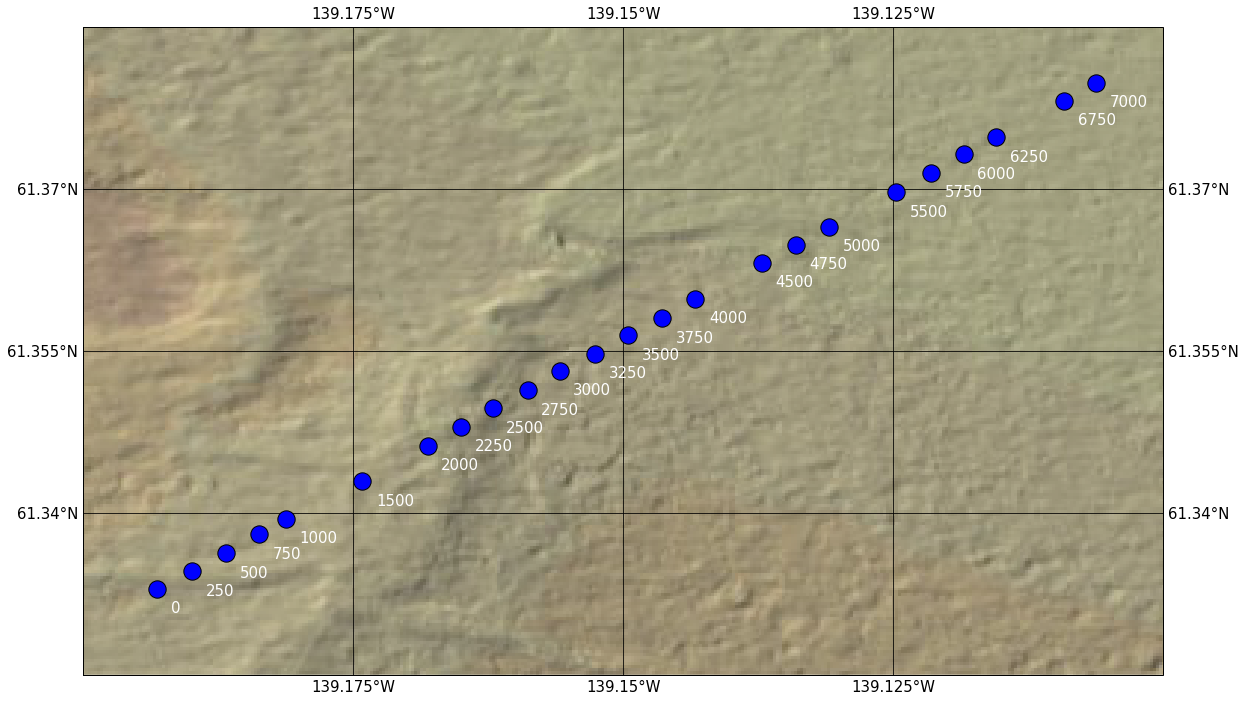

In [53]:
cartopy_mapping.plot_map_mt_objs(mt_objs)

MtPy does provide an interface for producing Occam2d inputs, but before we proceed we need to define:

1) **A profile angle** to perform the inversion

2) **A geoelectric strike** to rotate the data to

3) **A list of frequencies** to interpolate over

**1**. If we use station '0' and station '7000', we can calculate an azimuth. This will be our profile angle

**2**. From notebook II we found that the most likely geoelectric strike was 135 degrees.

**3**. Based on the range of data, we know that our minimum frequency is 11Hz and our max is 1440, with 8 discrete frequencies.

In [54]:
g = Geod(ellps="WGS84") 
st_0  = MT(edi_path+os.sep+'0.edi')
st_7k = MT(edi_path+os.sep+'7000.edi')
st_0_lat,  st_0_lon  = st_0.lat,  st_0.lon
st_7k_lat, st_7k_lon = st_7k.lat, st_7k.lon
az12,az21,dist = g.inv(st_0_lon,st_0_lat,st_7k_lon,st_7k_lat)
print(' Profile Azimuth: {} \n Profile Backazimuth: {}\n Profile Length: {}'.format(az12,az21,dist))
profile_angle = az12

 Profile Azimuth: 41.671473355665896 
 Profile Backazimuth: -138.25219754076625
 Profile Length: 6993.363108631992


So our forward azimuth for the profile is 41.7 degrees, with a total profile length of almost 7 kilometers

In [55]:
geoelectric_strike = 130

Even though we found the geoelectric strike was previously probably 135, Setting it to 130 will put it in better alignment with the stations.

In [56]:
frequencies = np.asarray([11,22,45,90,180,360,720,1440])

8 total frequencies between 11Hz and 1440Hz.

Occam2D needs 3 files:

* A Data file
* A Mesh/Model file
* A Startup file

So lets get started!

### Data File Setup
First, lets make the Data File. MtPy's occam_rewrite provides a ```Data``` class for this purpose. The documentation is not updated, but you can find descriptions of the arguments [here](https://github.com/MTgeophysics/mtpy/blob/develop/mtpy/modeling/occam2d_rewrite.py#L2024).

calling ```write_data_file()``` will produce the Occam2D data file along with a map of the original vs projected stations. I have a hunch that MtPy doesn't handle geoelectric strike vs profile angle appropriately, but visually confirming the projected stations are as close to the actual station map as possible gives me confidence the inversion will be informative.

Rotated Z and Tipper to align with +130.00 degrees E of N
Profile angle is +220.00 degrees E of N


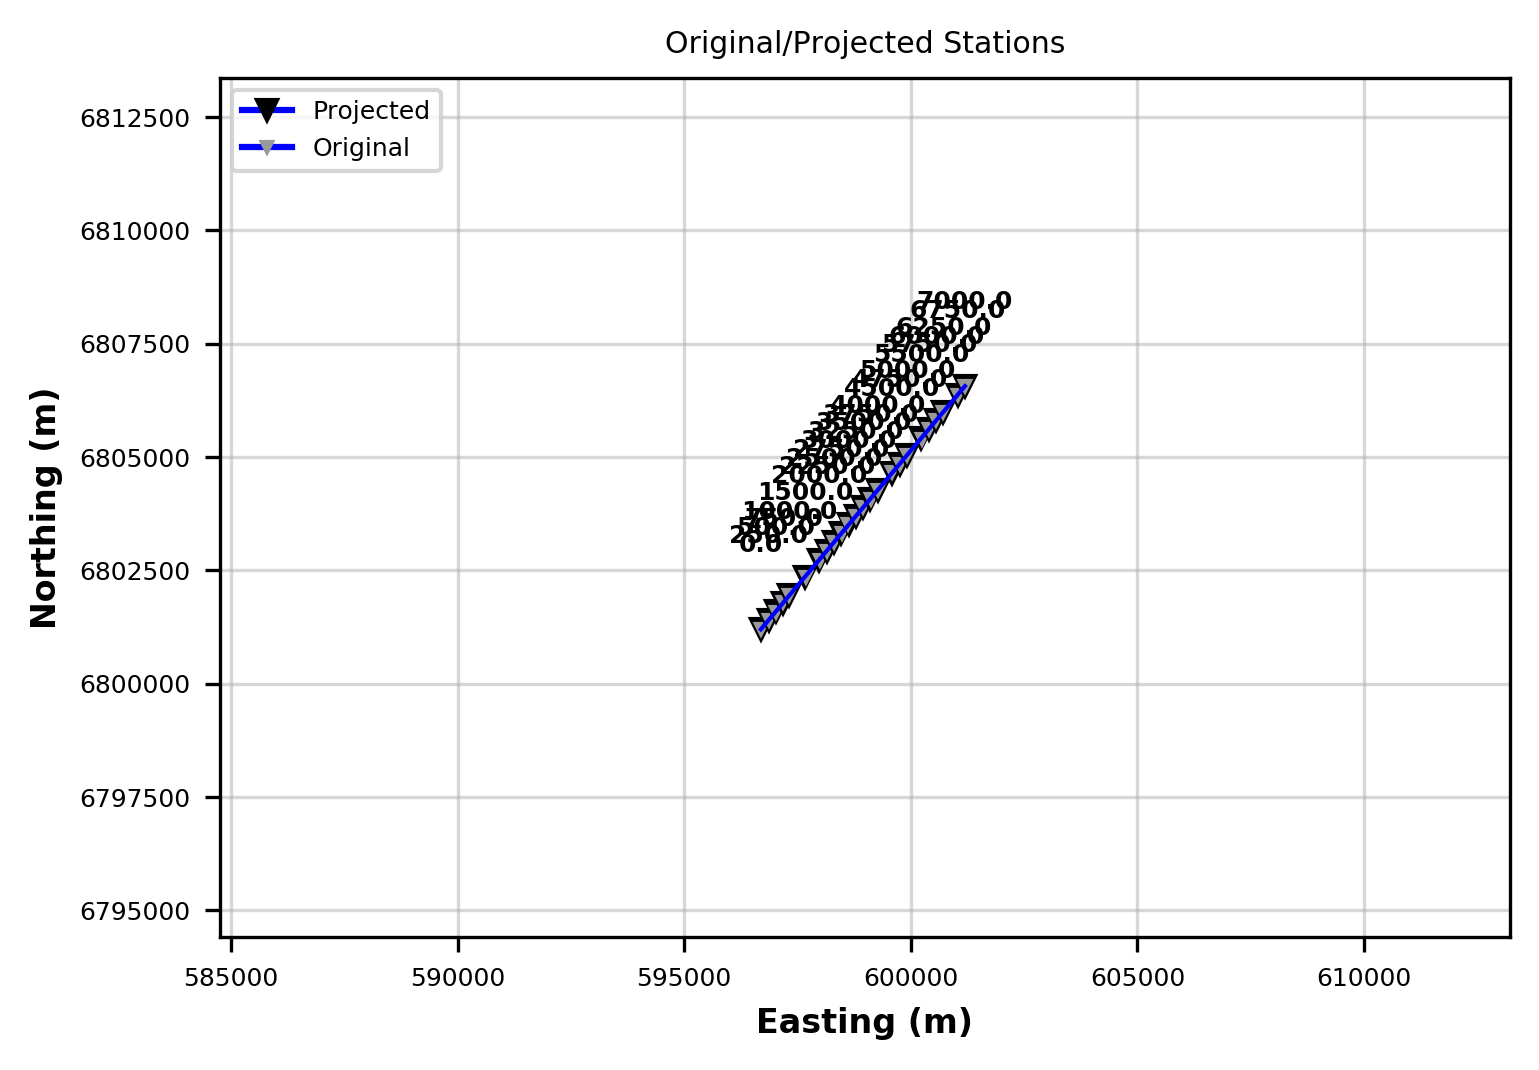

Wrote Occam2D data file to occam2d_inv/OccamDataFile.dat


In [57]:
data_file_kwargs = {
    'edi_path' : edi_path,
    'save_path': save_path,
    'model_mode': 'tip',
    'profile_angle': profile_angle,
    'geoelectric_strike': geoelectric_strike,
    'freq': frequencies,
    'tipper_err' : 5
}

occam_data_object = occam2d.Data(**data_file_kwargs)
occam_data_object.write_data_file()

The projected vs original stations are almost entirely co-located, so it appears we have a projected data file which is likely to work!

Next, we need to make model and mesh files. To do this we need to define:

1) **Number of Layers**. Lets set this to 60.

2) **Cell Width**. A rule of thumb is to ensure at least 3 cells between stations to localise any static shifts that may be due to heterogeneity under the stations. Our stations are distributed at 250m intervals, so 250/3 = 83m is a good cell width to aim for.

3) **A Pad Multiplier**. This multiplier geometrically increases the padding cells. Lets use 1.7.

4) **Small Cell Padding**. Number of small cells to pad by before geometrically increasing them. I'll use 3 to keep it consistent with the estimated inter station spacing

5) **Block Aspect Ratio**, also known as trigger. Again, I'll keep this in line with the user manual. 0.25

6) **Lowest depth of model**. We could play around with this or we can use a quick skin-depth calculation to estimate the maximum depth. Recall for Magnetotellurics the skin depth is:
$$depth\approx 500\sqrt{\frac{\rho_a}{f}}$$

on the extreme end of things, with dry igneous rocks we could expect a halfspace filled with a conductivity of $10^3 \Omega \cdot m$. In this case, and at 11 Hz our skin depth would be:
$$5km\approx 500\sqrt{\frac{10^3}{11}}$$

Likely this is in excess of what we need. We can contract the model later depending on our findings.

7) **Top Layer Thickness**. This thickness is important for determining the degree of model variance we may explain away due to surface heterogeneity. Again, we can use the skin depth equation, assuming an apparent resistivity equivalent to that of 'young sediments' at $10^0 \Omega \cdot m$, and the highest frequency available.
$$13m\approx 500\sqrt{\frac{1}{1440}}$$

I'll use 5 as a way to reduce any surface galvanic distortion from penetrating further into the model, and to hedge my bets on any possible water logged meadows or streams which may be under some of the stations.

8) **Inversion Target Depth**. Documentation is lacking on how this affects the inversion, but I'll set this to 3km for now.


I need to call five methods after creating our occam_model_object:

* **build_mesh()**. Calculates all the nodes and edges for the inversion mesh.

* **plot_mesh()**. Will show us a handy visual representation of the mesh object.

* **build_regularization()**. I assume this calculates some type of regularization object related to the roughness penalty term in the Occam paper.

* **write_mesh_file()**. Writes a mesh file to disk.

* **write_regularization_file()**. Writes regularization file to disk


                    MESH PARAMETERS                    
  number of horizontal nodes = 112
  number of vertical nodes   = 50
  Total Horizontal Distance  = 34710.521879
  Total Vertical Distance    = 18636.000000
               REGULARIZATION PARAMETERS               
   binding offset       = 0.0
   number layers        = 45
   number of parameters = 1731
   number of free param = 1731
                    MESH PARAMETERS                    
  number of horizontal nodes = 112
  number of vertical nodes   = 50
  Total Horizontal Distance  = 34710.521879
  Total Vertical Distance    = 18636.000000


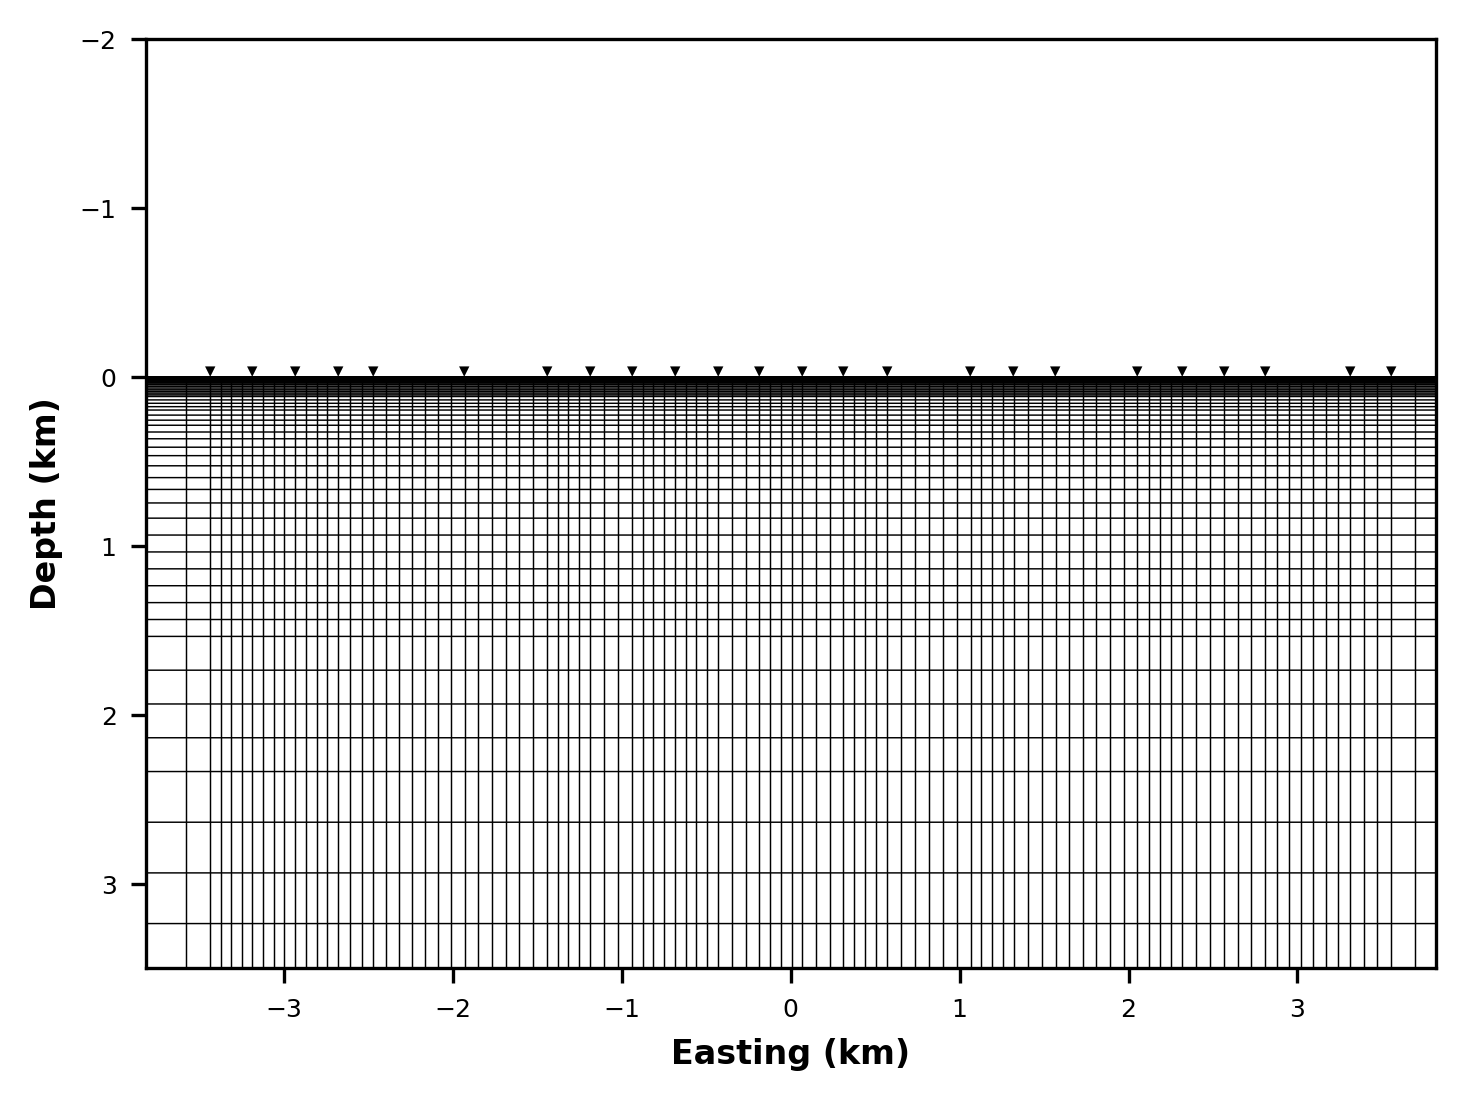

               REGULARIZATION PARAMETERS               
   binding offset       = 0.0
   number layers        = 45
   number of parameters = 1731
   number of free param = 1731
Wrote Mesh file to occam2d_inv/Occam2DMesh
Wrote Regularization file to occam2d_inv/Occam2DModel


In [58]:
occam_model_kwargs = {
    'station_locations':occam_data_object.station_locations,
    'save_path':save_path,
    'n_layers':50,
    'cell_width':83,
    'num_x_pad_small_cells':5,
    'x_pad_multiplier': 1.7,
    'trigger': 0.25,
    'z_bottom': 12000,
    'z1_layer':5,
    'z_target_depth':3500    
}

occam_model_object = occam2d.Regularization(**occam_model_kwargs)

occam_model_object.build_mesh()
occam_model_object.plot_mesh()
occam_model_object.build_regularization()
occam_model_object.write_mesh_file()
occam_model_object.write_regularization_file()

The last thing to do is to create a startup file. Parameters we can adjust are

* **Background Resistivity**. in log10 units. 100 $\Omega \cdot m$ (i.e. 2 log units) is a safe starting resistivity.

* **Number of Iterations**. Start small and work up until you reach an optimum misfit value. First, lets start with 1.

* **Target Misfit**. Target rms data to stop iterating at. This is highly dependent on how big your model is, and how much it overlaps with your data. Use 1 for now.

* **Diagonal Penalties**. If the model should penalize diagonal terms, simple 1 for yes, 0 for no.

then run ```write_startup_file()``` to write the file to disk.

In [59]:
occam_startup_kwargs = {
    'save_path':save_path,
    'iterations_to_run':1,
    'resistivity_start':2.0,
    'target_misfit':1e-4,
    'diagonal_penalties':0,
    'debug_level':2,
    'data_fn':os.path.join(occam_data_object.data_fn),
    'param_count':occam_model_object.num_free_param,
    'model_fn':occam_model_object.reg_fn
}

occam_startup_file=occam2d.Startup(**occam_startup_kwargs)
occam_startup_file.write_startup_file()

Wrote Occam2D startup file to occam2d_inv/Occam2DStartup


### Install Fortran and Identify Binary

First, download OCCAM2DMT_V3.0.zip from https://marineemlab.ucsd.edu/Projects/Occam/2DMT/index.html. Extract the zipped file to a directory you wish to work from.


Next, make sure you have FORTRAN90 installed somehow. For linux I installed it via gfortran like so:

```
sudo apt-get install gfortran
[sudo] password for <username>:         
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
Suggested packages:
    ....
    .....
Need to get 42.1 MB of archives.
After this operation, 33.8 MB of additional disk space will be used.
Do you want to continue? [Y/n]
```
Then type 'Y' and hit enter.

For OSX, follow the directions here: https://www.webmo.net/support/fortran_osx.html. Occam2D may have some issues with Absoft, so either use gcc or gfortran.

For Windows, follow the directions here https://gcc.gnu.org/wiki/GFortranBinaries.

Ok, now that you've installed it you can either:

* Run the precompiled binaries under the ```binaries``` folder in the unzipped OCCAM2DMT_V3.0.zip

* Compile your own binary.

You should probably do the first one unless you are on linux or like pain. Unfortunatley, I'm on linux.


### If you have to compile your own binary

What I had to do is edit ```MakeFile``` under the ```source``` folder with the following substitutions for the FC90 and FCFlAGS variables:

**Original**
```
FC90    = f90
FCFLAGS = -O2
```
**Modified**
```
FC90    = gfortran
FCFLAGS = -O2 -Wall

```

The compiler will run and spit out some warnings. Ignore them, they look complicated. Finally, it will produce a binary file called ```Occam2D``` use this for the next part

### Or Use a Precompiled Option

If you want to use a precompiled binary, navigate to the ```binaries``` folder in your zip, find the ```Occam2D``` binary of relevance to you, and move it to the folder we defined earlier as ```occam2d_inv```.

### Run Occam2D 

There are three options you can provide Occam if you choose, but i'll just explicitly run you through a simple example.

in the terminal (or powershell on windows), navigate to the ```occam2d_inv``` folder. Use the following command to execute Occam2D:

```
./Occam2D Occam2DStartup <appended_file_string>
```
I used 'test' in place of ```<appended_file_string>```. The inversion should immediately run. You'll see a ton of output, including some worrying warnings. Ignore this for now.

When it finishes and quits running, it should have saved a few different files to disk:

* testXX.iter: the output mesh file at a particular iteration.
* testXX.resp: the output station response file at an iteration.
* test.logfile: the logs recorded by the inversion.

Go ahead and choose one of the iteration files to plot, say ```test01.iter```.

In [62]:
"""
HELPER CELL

helps plot the 2D inversion result

"""

def plot_2d_section(file,datafn):
    fig = plt.figure(figsize=(15,25))
    pltm     = PlotModel(iter_fn=file,data_fn=datafn,xpad=3,yscale = 'm',climits=(0,3),station_font_pad=0.1,
                   dpi=150,fig_aspect = 1.0,ylimits = (0,16),cmap=cmap.get_cmap('jet_r'),cb_shrink= 0.2)

Reading from occam2d_inv/OccamDataFile.dat
    profile_angle = 220.0
    geoelectric_strike = 130.0
    number of sites = 24
    number of frequencies = 8


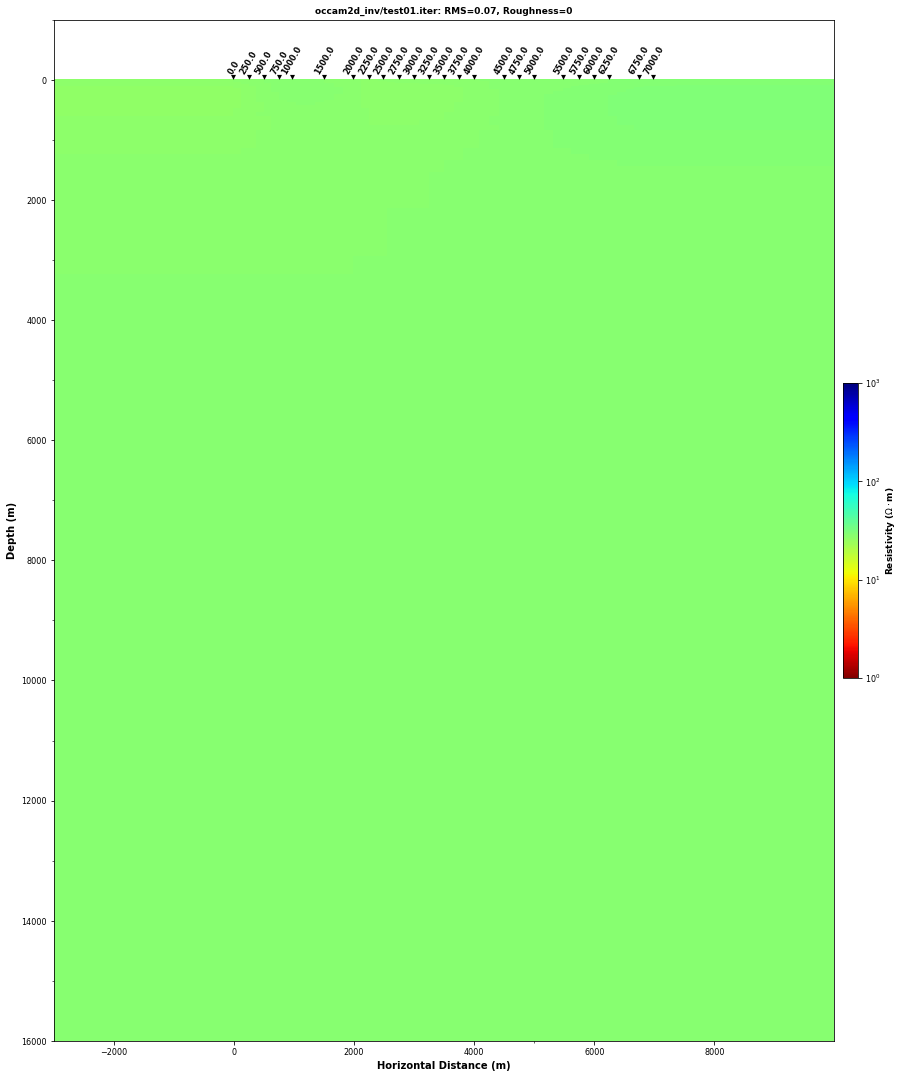

In [63]:
iterfile = 'occam2d_inv/test01.iter'
datafn   = 'occam2d_inv/OccamDataFile.dat'
plot_2d_section(iterfile,datafn)

I still have a long way to go to refine the setup, but you should get a sense of how to run Occam2D at the very least.


# Step 5. Explore Inversion Parameters

Geophysical Inversion can be a deterministic, rigid process of slowly descending down model gradients. However, the final result depends heavily on the problem setup. Ideally I'd like to produce a model that illustrates the major features required to match the data. I'd also like a mesh that covers the area of interest and provides nice boundary conditions for the problem. Finally, I'd like to accomplish both but not in a way that overfits the problem and that executes in a human timescale.

The first step is to determine the rms level I should be aiming for. I'll condense the above cells into a handy function call so I can succintly redefine my problem. The way I've wrote it makes it easy to pass only the new parameters we want to the file creation routines, but be advised there are defaults here.

In [64]:
"""

HELPER CELLS

creates all the occam data files you could want with a handy call

"""

def create_occam_objects(**kwargs):
    files_to_remove = ['Occam2DMesh','Occam2DModel','Occam2DStartup','OccamDataFile.dat']
    for file in files_to_remove:
        os.remove(os.path.join(save_path,file))
    data_file_kwargs = {
        'edi_path' : edi_path,
        'save_path': save_path,
        'model_mode': 'tip',
        'profile_angle': profile_angle,
        'geoelectric_strike': geoelectric_strike,
        'freq': frequencies,
        'tipper_err' : 5
    }
    occam_model_kwargs = {
        'save_path':save_path,
        'n_layers':50,
        'cell_width':83,
        'num_x_pad_small_cells':5,
        'x_pad_multiplier': 1.7,
        'trigger': 0.25,
        'z_bottom': 12000,
        'z1_layer':5,
        'z_target_depth':3500    
    }
    occam_startup_kwargs = {
        'save_path':save_path,
        'iterations_to_run':1,
        'resistivity_start':2.0,
        'target_misfit':1e-4,
        'diagonal_penalties':0,
        'debug_level':2,
    }
    for key, value in kwargs.items():
        if key in data_file_kwargs.keys():
            data_file_kwargs[key]    = value
        elif key in occam_model_kwargs.keys():
            occam_model_kwargs[key]  = value
        elif key in occam_startup_kwargs.keys():
            occam_startup_kwargs[key]= value
            
    occam_data_object = occam2d.Data(**data_file_kwargs)
    occam_data_object.write_data_file()
    occam_model_kwargs['station_locations']=occam_data_object.station_locations
    occam_model_object = occam2d.Regularization(**occam_model_kwargs)

    occam_model_object.build_mesh()
    occam_model_object.build_regularization()
    occam_model_object.write_mesh_file()
    occam_model_object.write_regularization_file()
    
    occam_startup_kwargs['data_fn']=os.path.join(occam_data_object.data_fn)
    occam_startup_kwargs['param_count']=occam_model_object.num_free_param
    occam_startup_kwargs['model_fn']=occam_model_object.reg_fn
    occam_startup_file=occam2d.Startup(**occam_startup_kwargs)
    occam_startup_file.write_startup_file()
    
    return occam_data_object, occam_model_object, occam_startup_file

Excellent. Now lets explore the rms level by setting  ```target_misfit``` to some low value and ```iterations_to_run``` to like, 150.

Rotated Z and Tipper to align with +130.00 degrees E of N
Profile angle is +220.00 degrees E of N


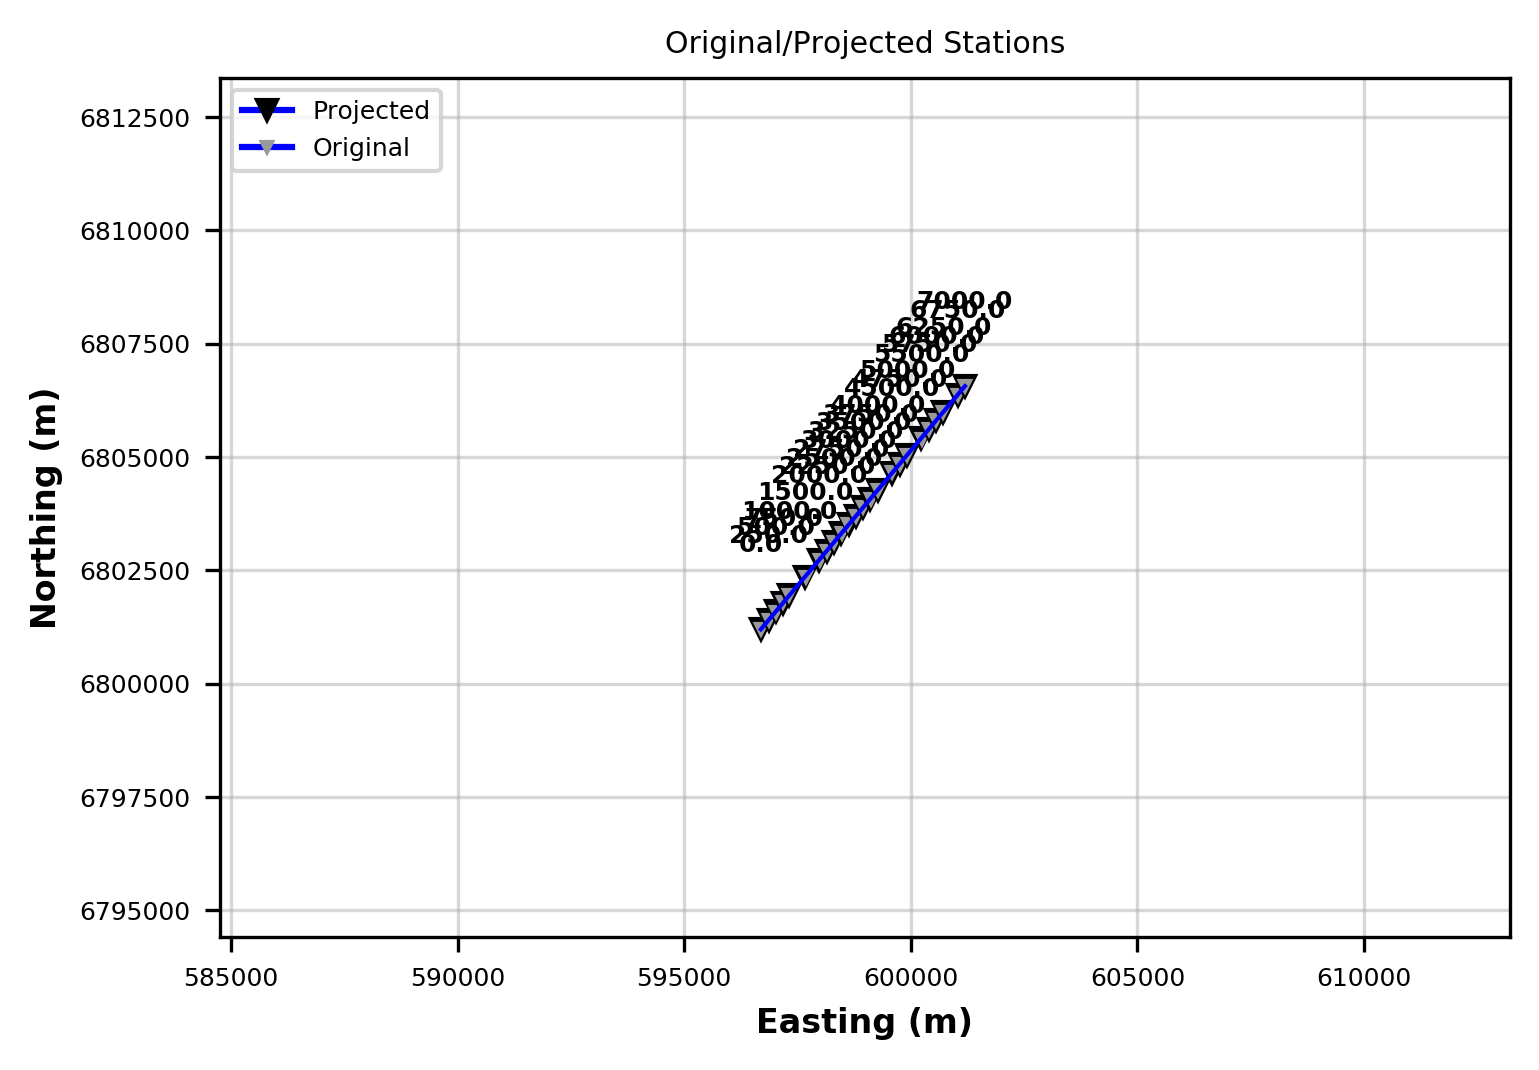

Wrote Occam2D data file to occam2d_inv/OccamDataFile.dat
                    MESH PARAMETERS                    
  number of horizontal nodes = 112
  number of vertical nodes   = 40
  Total Horizontal Distance  = 34710.521879
  Total Vertical Distance    = 18570.000000
               REGULARIZATION PARAMETERS               
   binding offset       = 0.0
   number layers        = 35
   number of parameters = 1277
   number of free param = 1277
                    MESH PARAMETERS                    
  number of horizontal nodes = 112
  number of vertical nodes   = 40
  Total Horizontal Distance  = 34710.521879
  Total Vertical Distance    = 18570.000000
               REGULARIZATION PARAMETERS               
   binding offset       = 0.0
   number layers        = 35
   number of parameters = 1277
   number of free param = 1277
Wrote Mesh file to occam2d_inv/Occam2DMesh
Wrote Regularization file to occam2d_inv/Occam2DModel
Wrote Occam2D startup file to occam2d_inv/Occam2DStartup


In [65]:
occam_data_object, occam_model_object, occam_startup_file=create_occam_objects(z1_layer=5,
                                                            target_misfit=1e-6,iterations_to_run=150)

go ahead and run Occam2D with the updated input files. Use a file string that indicates this run is for rms testing.
```
./Occam2D Occam2DStartup rms_test
```
This will take awhile. I reccomend getting a beer, coffee, or similar while you wait. 

....

...

..

.

You might be interested to know that this process is very similar to training Neural Nets in machine learning. Infact, Neural Net training has gradients, step sizes, misfits, and regularization just like in Geophysical Inversion. The only difference is here, we know the physics, even if its hard to calculate. 

.

..

...

....

Oops. Looks like the run finished early, at only 23 iterations. 

In [139]:
"""

HELPER CELL

reads in information about the misfit and roughness at every iteration

"""

def extract_roughness(file):
    phrase = 'Roughness Value'
    with open(file) as f:
        for i, line in enumerate(f, 1):
            if phrase in line:
                line_number = i
                line_text   = line
                break
                
        number = float(line_text.replace(" ", "").split(':')[-1])
    return number
    
def extract_misfit(file):
    phrase = 'Misfit Value'
    with open(file) as f:
        for i, line in enumerate(f, 1):
            if phrase in line:
                line_number = i
                line_text   = line
                break

        number = float(line_text.replace(" ", "").split(':')[-1])
    return number
  
def create_filename(iterations,file_prefix):
    test_file_name = '{}{}.iter'.format(file_prefix,str(iterations).zfill(2))
    test_path      = os.path.join(save_path,test_file_name)
    return test_path
    
def create_arrays(file_prefix):
    total_iterations     =-1
    while True:
        total_iterations+= 1
        test_file_name   = create_filename(total_iterations,file_prefix)
        if not os.path.isfile(test_file_name):
            total_iterations-= 1
            break
    misfit    = []
    roughness = []
    for i in range(0,total_iterations):
        test_file_name = create_filename(i,file_prefix)
        misfit.append(extract_misfit(test_file_name))
        roughness.append(extract_roughness(test_file_name))
        
    misfit    = np.asarray(misfit)
    roughness = np.asarray(roughness)
    
    data = np.vstack((misfit,roughness))
    
    return data

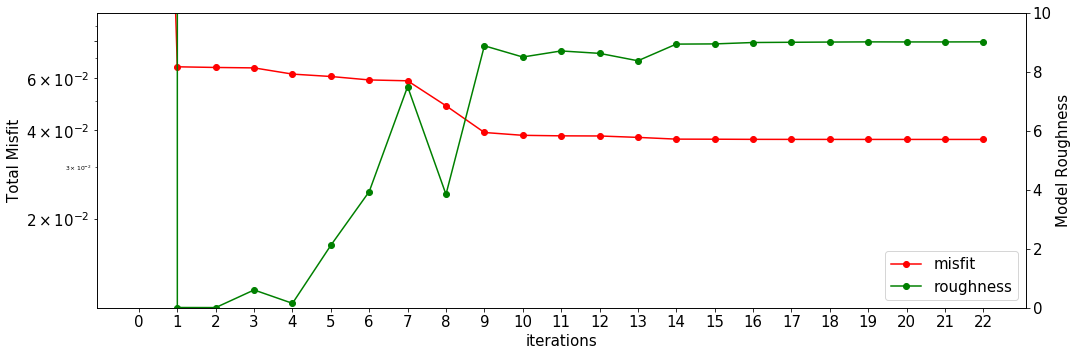

In [148]:
data = create_arrays('rms_test')
plt.figure(figsize=(15,5))
misfit,=plt.semilogy(list(range(data.shape[-1])),data[0,:],marker='o',color='red',label='misfit')
ax1 = plt.gca()
ax2 = ax1.twinx()
roughness,=ax2.plot(list(range(data.shape[-1])),data[1,:],marker='o',color='green',label='roughness')
ax2.set_ylim([0,10])
ax1.set_ylim([0.01,0.1])
ax1.set_yticks([2e-2,4e-2,6e-2,8e-2])
ax1.set_ylabel('Total Misfit',fontsize=15)
ax2.set_ylabel('Model Roughness',fontsize=15)
ax1.set_xticks(list(range(data.shape[-1])))
ax1.tick_params(axis='x', labelsize=15 )
ax1.tick_params(axis='y', labelsize=15 )
ax2.tick_params(axis='y', labelsize=15 )
ax1.set_xlabel('iterations',fontsize=15)
plt.legend([misfit,roughness],['misfit','roughness'],loc='lower right',fontsize=15)
plt.show()

What I'm looking for is a point at which the total misfit rms value is near its minimum with the least amount of 'structure' as indicated by the roughness series. On my graph this happens around a value of $rms=4\times10^{-2}$. However, this was done without diagonal penalties. What if we include diagonal pentalties?

Rotated Z and Tipper to align with +130.00 degrees E of N
Profile angle is +220.00 degrees E of N


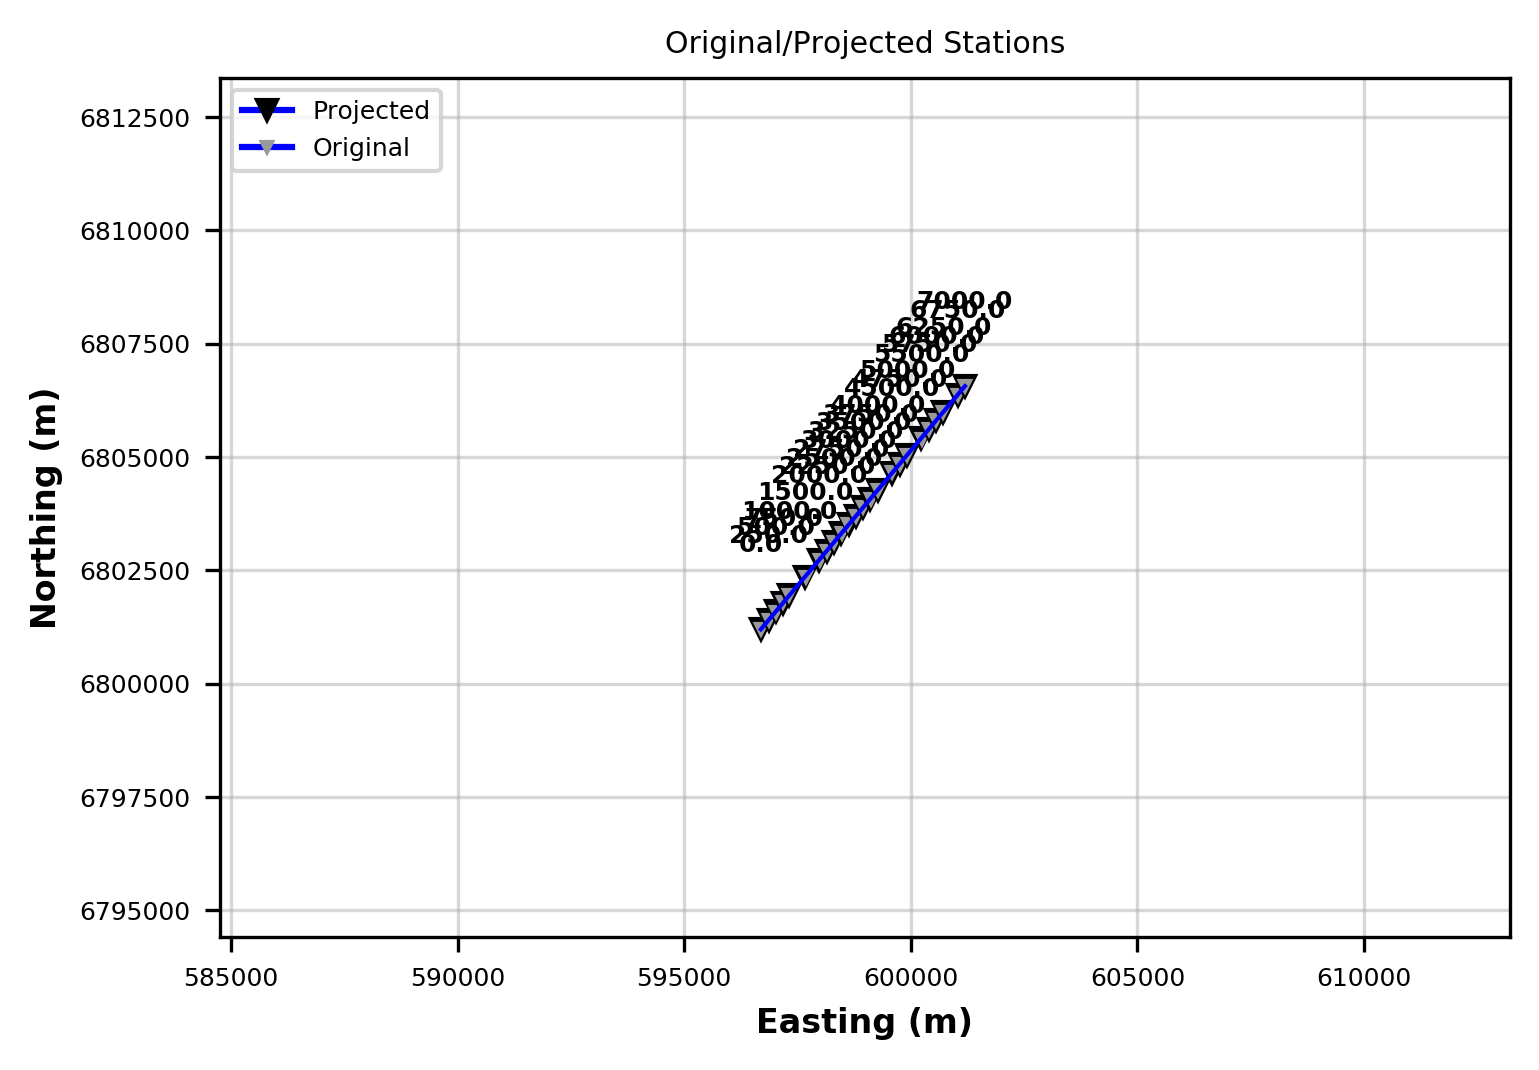

Wrote Occam2D data file to occam2d_inv/OccamDataFile.dat
                    MESH PARAMETERS                    
  number of horizontal nodes = 112
  number of vertical nodes   = 40
  Total Horizontal Distance  = 34710.521879
  Total Vertical Distance    = 18570.000000
               REGULARIZATION PARAMETERS               
   binding offset       = 0.0
   number layers        = 35
   number of parameters = 1277
   number of free param = 1277
                    MESH PARAMETERS                    
  number of horizontal nodes = 112
  number of vertical nodes   = 40
  Total Horizontal Distance  = 34710.521879
  Total Vertical Distance    = 18570.000000
               REGULARIZATION PARAMETERS               
   binding offset       = 0.0
   number layers        = 35
   number of parameters = 1277
   number of free param = 1277
Wrote Mesh file to occam2d_inv/Occam2DMesh
Wrote Regularization file to occam2d_inv/Occam2DModel
Wrote Occam2D startup file to occam2d_inv/Occam2DStartup


In [138]:
occam_data_object, occam_model_object, occam_startup_file=create_occam_objects(z1_layer=5,diagonal_penalties=1,
                                                            target_misfit=1e-6,iterations_to_run=150)

After running the above cell, use a file string that indicates this run is for diagonal rms testing.
```
./Occam2D Occam2DStartup rms_diag_test
```

as before, kick back and wait for everything to come to a complete stop.

...

..

.

This run finished early as well, at only 41 iterations. Lets go ahead and look at the rms trends.

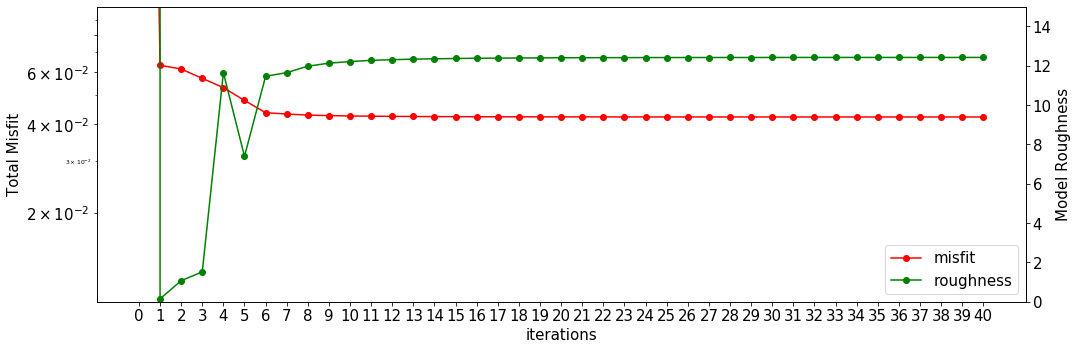

In [150]:
data = create_arrays('rms_diag_test')
plt.figure(figsize=(15,5))
misfit,=plt.semilogy(list(range(data.shape[-1])),data[0,:],marker='o',color='red',label='misfit')
ax1 = plt.gca()
ax2 = ax1.twinx()
roughness,=ax2.plot(list(range(data.shape[-1])),data[1,:],marker='o',color='green',label='roughness')
ax2.set_ylim([0,15])
ax1.set_ylim([0.01,0.1])
ax1.set_yticks([2e-2,4e-2,6e-2,8e-2])
ax1.set_ylabel('Total Misfit',fontsize=15)
ax2.set_ylabel('Model Roughness',fontsize=15)
ax1.set_xticks(list(range(data.shape[-1])))
ax1.tick_params(axis='x', labelsize=15 )
ax1.tick_params(axis='y', labelsize=15 )
ax2.tick_params(axis='y', labelsize=15 )
ax1.set_xlabel('iterations',fontsize=15)
plt.legend([misfit,roughness],['misfit','roughness'],loc='lower right',fontsize=15)
plt.show()

The addition of a diagonal penalty term caused a higher average misfit, but with a faster convergence rate. The Model roughness is much higher as well, which makes sense given the second misfit term used. 

To summarize, we have two target parameter combinations which may work:

* Misfit condition around $4\times10^{-2}$ with no diagonal penalty and 10 iterations max.

* Misfit condition around $4.5\times10^{-2}$ with a diagonal penalty and 8 iterations max.

What do these models look like? Well, lets run it again and see.

For parameter combo 1:

Rotated Z and Tipper to align with +130.00 degrees E of N
Profile angle is +220.00 degrees E of N


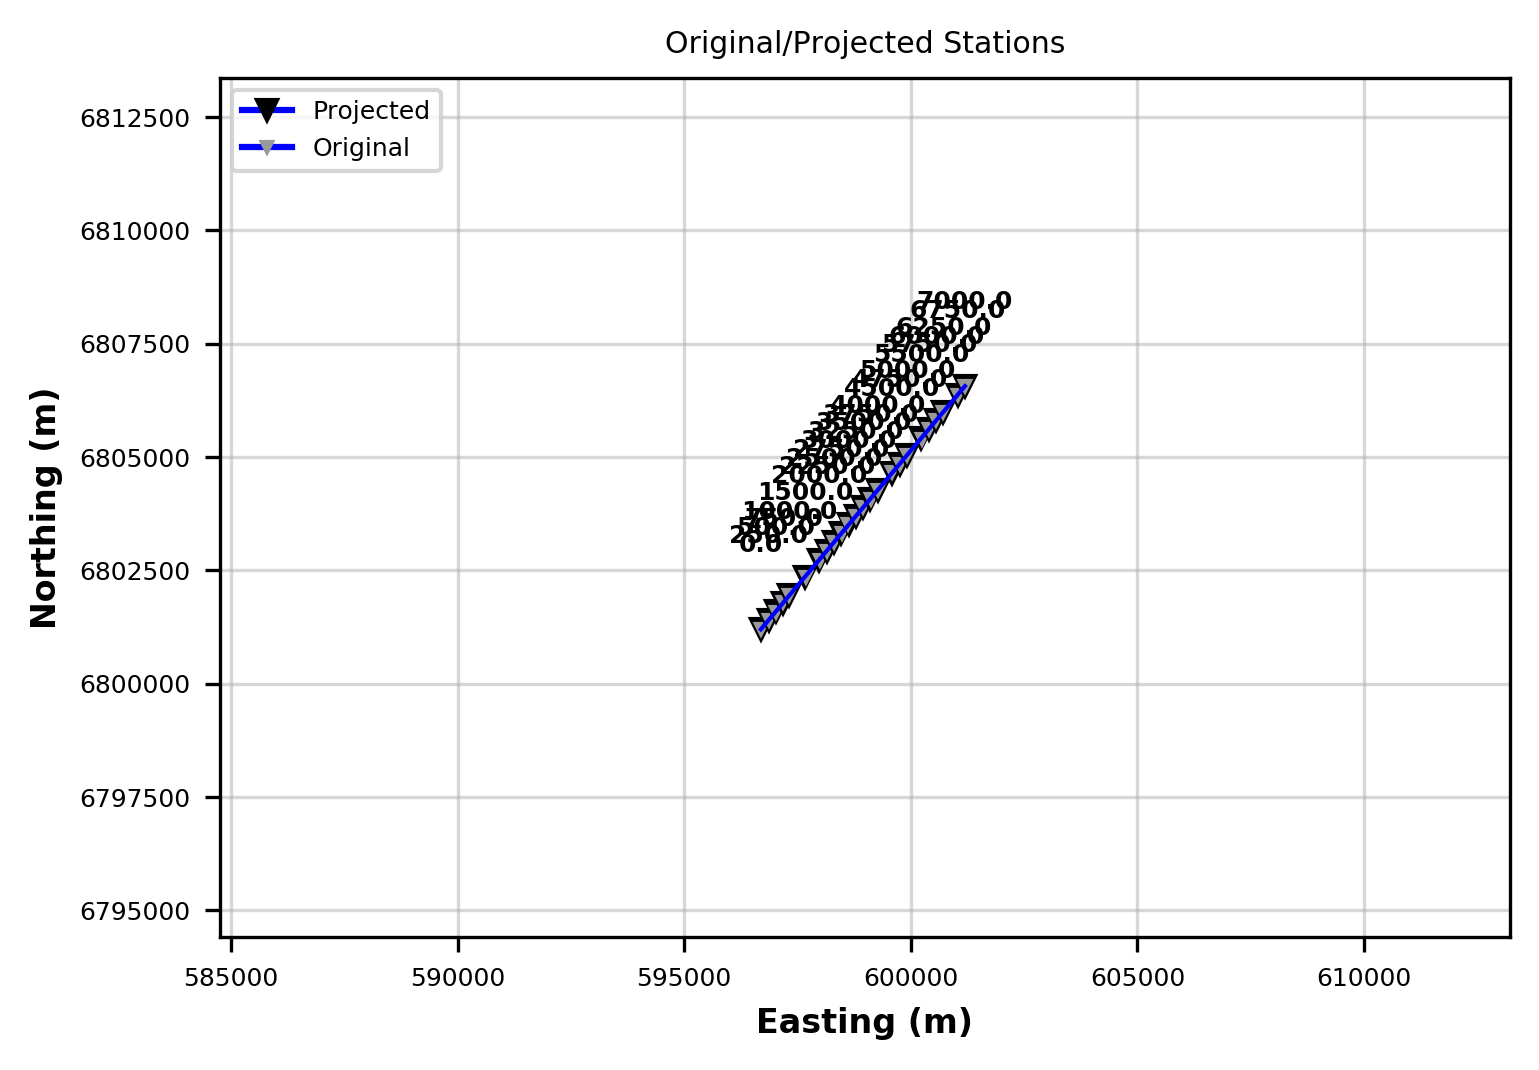

Wrote Occam2D data file to occam2d_inv/OccamDataFile.dat
                    MESH PARAMETERS                    
  number of horizontal nodes = 112
  number of vertical nodes   = 40
  Total Horizontal Distance  = 34710.521879
  Total Vertical Distance    = 18570.000000
               REGULARIZATION PARAMETERS               
   binding offset       = 0.0
   number layers        = 35
   number of parameters = 1277
   number of free param = 1277
                    MESH PARAMETERS                    
  number of horizontal nodes = 112
  number of vertical nodes   = 40
  Total Horizontal Distance  = 34710.521879
  Total Vertical Distance    = 18570.000000
               REGULARIZATION PARAMETERS               
   binding offset       = 0.0
   number layers        = 35
   number of parameters = 1277
   number of free param = 1277
Wrote Mesh file to occam2d_inv/Occam2DMesh
Wrote Regularization file to occam2d_inv/Occam2DModel
Wrote Occam2D startup file to occam2d_inv/Occam2DStartup


In [151]:
occam_data_object, occam_model_object, occam_startup_file=create_occam_objects(z1_layer=5,diagonal_penalties=0,
                                                            target_misfit=4e-2,iterations_to_run=10)

Send it to the CPU!
```
./Occam2D Occam2DStartup optimized_no_diag
```
...

..

.

When finished, my terminal says it completes at iteration 10. So lets look at the transect.

Reading from occam2d_inv/OccamDataFile.dat
    profile_angle = 220.0
    geoelectric_strike = 130.0
    number of sites = 24
    number of frequencies = 8


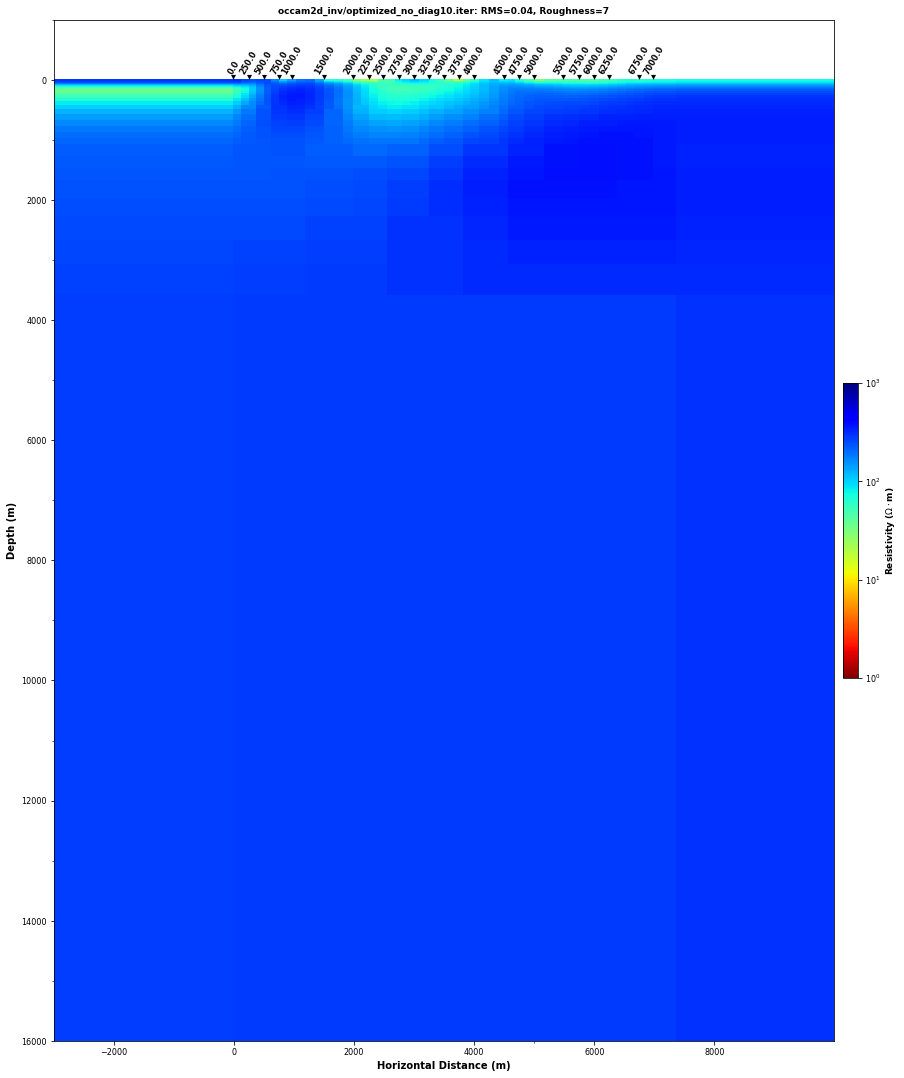

In [152]:
iterfile = 'occam2d_inv/optimized_no_diag10.iter'
datafn   = 'occam2d_inv/OccamDataFile.dat'
plot_2d_section(iterfile,datafn)

Ah, there are some interesting anomalies under the line. Lets redefine the plot limits to better see. No need to look down 16km of crust

In [157]:
def plot_2d_section(file,datafn):
    fig = plt.figure(figsize=(15,25))
    pltm     = PlotModel(iter_fn=file,data_fn=datafn,xpad=3,yscale = 'm',climits=(1,2.5),station_font_pad=0.1,
                   dpi=150,fig_aspect = 1.0,ylimits = (0,5),cmap=cmap.get_cmap('jet_r'),cb_shrink= 0.2)

Reading from occam2d_inv/OccamDataFile.dat
    profile_angle = 220.0
    geoelectric_strike = 130.0
    number of sites = 24
    number of frequencies = 8


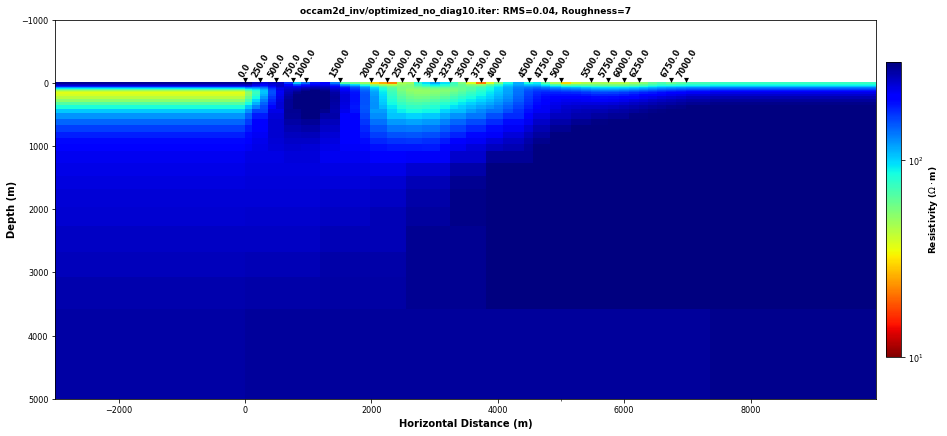

In [159]:
iterfile = 'occam2d_inv/optimized_no_diag10.iter'
datafn   = 'occam2d_inv/OccamDataFile.dat'
plot_2d_section(iterfile,datafn)

It is tempting to interpret this section immediately, but lets hold off on it. How does this profile compare to the one with a diagonal penalty?

Rotated Z and Tipper to align with +130.00 degrees E of N
Profile angle is +220.00 degrees E of N


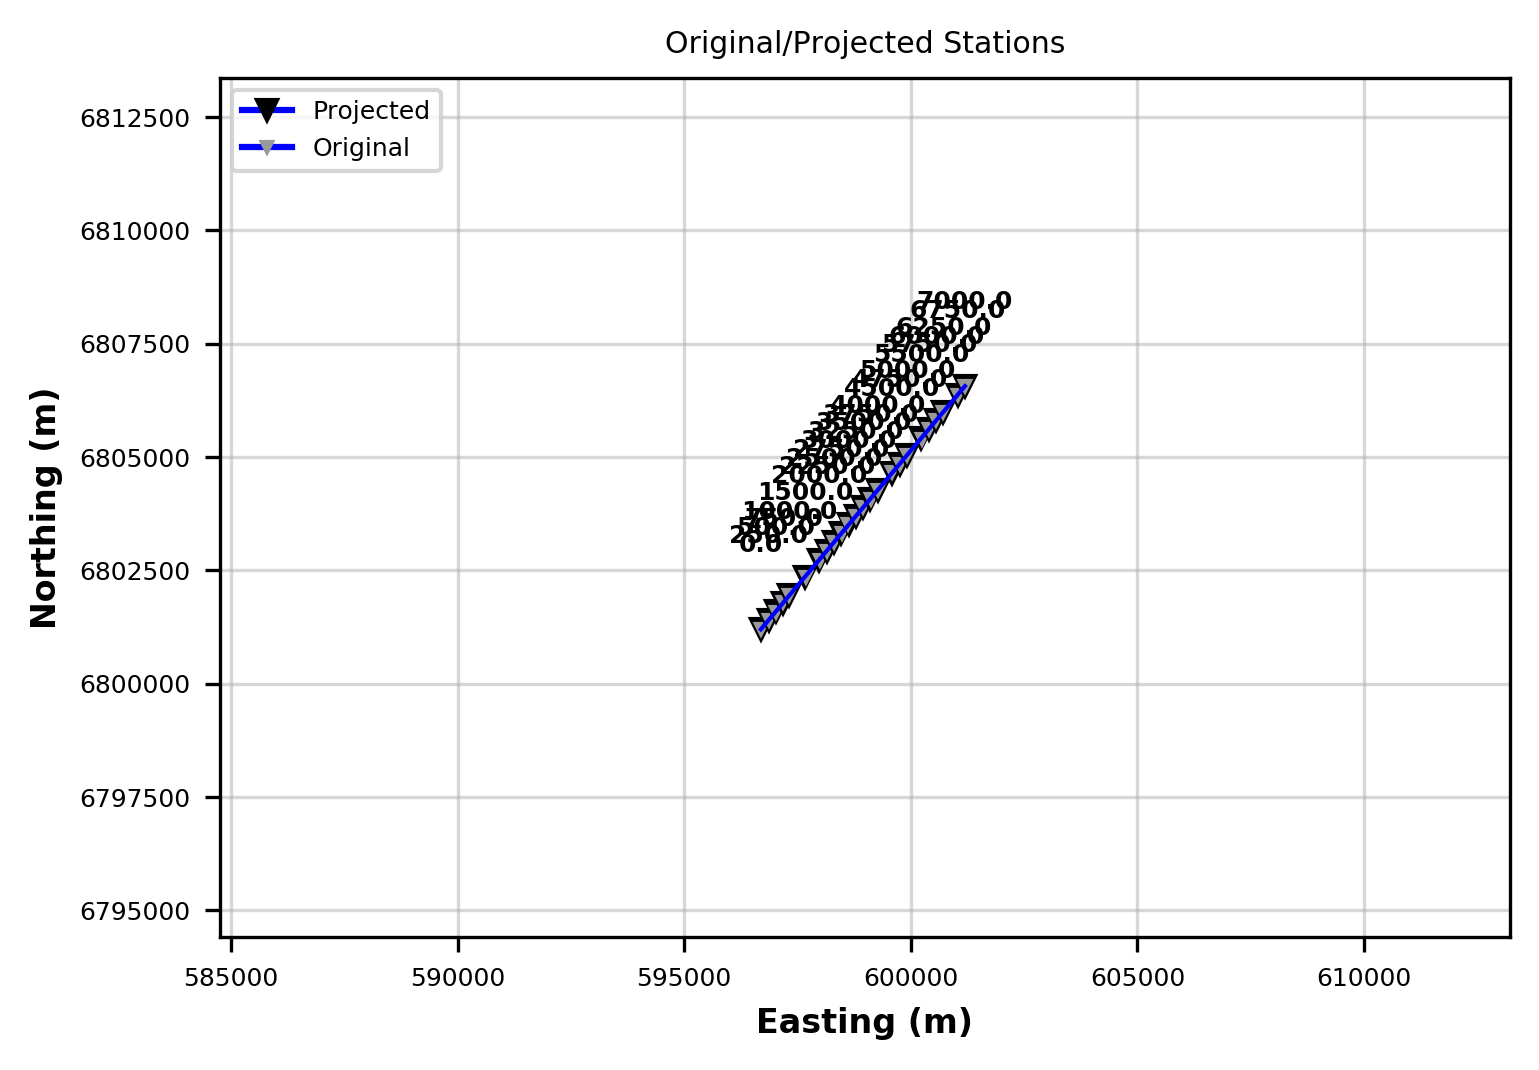

Wrote Occam2D data file to occam2d_inv/OccamDataFile.dat
                    MESH PARAMETERS                    
  number of horizontal nodes = 112
  number of vertical nodes   = 40
  Total Horizontal Distance  = 34710.521879
  Total Vertical Distance    = 18570.000000
               REGULARIZATION PARAMETERS               
   binding offset       = 0.0
   number layers        = 35
   number of parameters = 1277
   number of free param = 1277
                    MESH PARAMETERS                    
  number of horizontal nodes = 112
  number of vertical nodes   = 40
  Total Horizontal Distance  = 34710.521879
  Total Vertical Distance    = 18570.000000
               REGULARIZATION PARAMETERS               
   binding offset       = 0.0
   number layers        = 35
   number of parameters = 1277
   number of free param = 1277
Wrote Mesh file to occam2d_inv/Occam2DMesh
Wrote Regularization file to occam2d_inv/Occam2DModel
Wrote Occam2D startup file to occam2d_inv/Occam2DStartup


In [160]:
occam_data_object, occam_model_object, occam_startup_file=create_occam_objects(z1_layer=5,diagonal_penalties=1,
                                                            target_misfit=4.5e-2,iterations_to_run=8)

Send it to the CPU!
```
./Occam2D Occam2DStartup optimized_diag
```
...

..

.

When finished, my terminal says it completes at iteration 8 within the misfit target! Lets look at the transect.

Reading from occam2d_inv/OccamDataFile.dat
    profile_angle = 220.0
    geoelectric_strike = 130.0
    number of sites = 24
    number of frequencies = 8


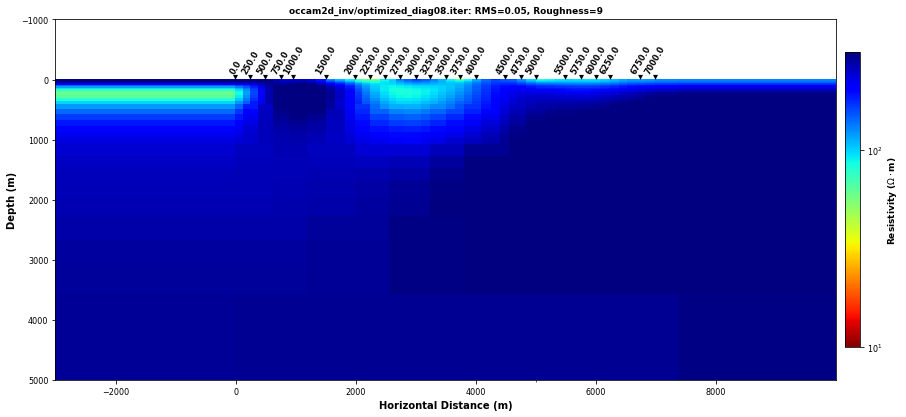

In [162]:
iterfile = 'occam2d_inv/optimized_diag08.iter'
datafn   = 'occam2d_inv/OccamDataFile.dat'
plot_2d_section(iterfile,datafn)

All of the anomalies present in the first approach are present in this one too, albeit to different degrees. 

In the next notebook I'll analyze these two models and attempt to interpret what we see in context of the data.